<a href="https://colab.research.google.com/github/niruthikka24/Customer-Churn-Dashboard/blob/master/ML_Mini_Project_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

customer_id wasn't present in any of the datasets used

Trial 1: - xgboost, 0,1 or 1,2,3 mappings for categorical variables - Score - 0.90555

Trial 2: - xgboost, removed columns that have high correlation with each other ('voice_mail_plan','total_day_min','total_eve_min','total_night_minutes','total_intl_minutes'), same mappings as above for categorical variables - Score - 0.90777, colab scores were lower though

Trial 3: - Same as trial 2. Changed xgb to lgbmclassifier - Score - 0.90333, colab scores were the highest out of the 3 trials

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# from lightgbm import plot_importance
from xgboost import plot_importance


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn import ensemble

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from yellowbrick.model_selection import validation_curve
import statsmodels.api as sm

In [ ]:
up1 = files.upload()

Saving Test_Dataset_190604N.csv to Test_Dataset_190604N.csv
Saving Train_Dataset_190604N.csv to Train_Dataset_190604N.csv


In [ ]:
df = pd.read_csv('Train_Dataset_190604N.csv')
df.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn
0,1001,15.0,452,no,no,0.0,121.1,130.0,20.59,216.0,86.0,18.36,235.1,33.0,10.58,16.1,5.0,4.35,2.0,No
1,1002,105.0,452,no,no,0.0,259.3,96.0,44.08,175.2,97.0,14.89,222.4,36.0,10.01,12.0,5.0,3.24,3.0,No
2,1003,97.0,452,no,yes,32.0,183.4,94.0,31.18,269.1,120.0,22.87,203.5,38.0,9.16,6.7,4.0,1.81,5.0,No
3,1004,121.0,445,no,yes,35.0,68.7,95.0,11.68,209.2,69.0,17.78,197.4,42.0,8.88,11.4,4.0,3.08,1.0,No
4,1005,98.0,452,no,yes,22.0,278.3,89.0,47.31,93.4,143.0,7.94,107.6,42.0,4.84,9.7,5.0,2.62,0.0,No


In [ ]:
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
df["intertiol_plan"] = df["intertiol_plan"].replace(scale_mapper)
df["voice_mail_plan"] = df["voice_mail_plan"].replace(scale_mapper)
df["Churn"] = df["Churn"].replace(scale_mapper1)
df["location_code"] = df["location_code"].replace(scale_mapper2)
df.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn
0,1001,15.0,2,0,0,0.0,121.1,130.0,20.59,216.0,86.0,18.36,235.1,33.0,10.58,16.1,5.0,4.35,2.0,0
1,1002,105.0,2,0,0,0.0,259.3,96.0,44.08,175.2,97.0,14.89,222.4,36.0,10.01,12.0,5.0,3.24,3.0,0
2,1003,97.0,2,0,1,32.0,183.4,94.0,31.18,269.1,120.0,22.87,203.5,38.0,9.16,6.7,4.0,1.81,5.0,0
3,1004,121.0,1,0,1,35.0,68.7,95.0,11.68,209.2,69.0,17.78,197.4,42.0,8.88,11.4,4.0,3.08,1.0,0
4,1005,98.0,2,0,1,22.0,278.3,89.0,47.31,93.4,143.0,7.94,107.6,42.0,4.84,9.7,5.0,2.62,0.0,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


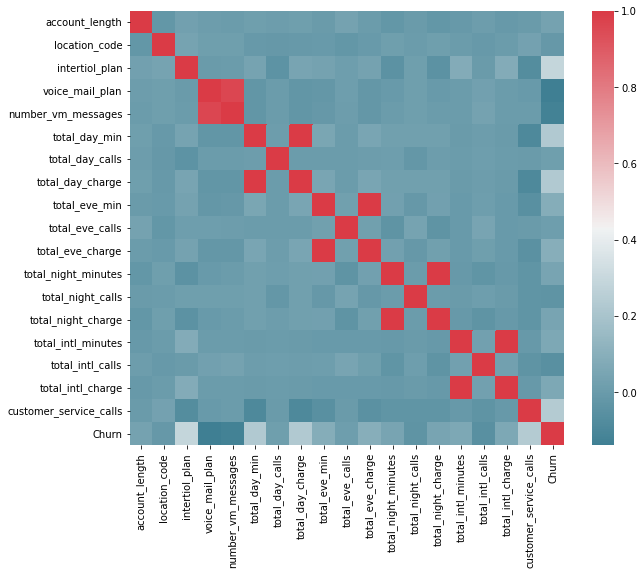

In [ ]:
df.drop(['customer_id'],axis=1,inplace=True)
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
df2 = df.drop(['voice_mail_plan','total_day_min','total_eve_min','total_night_minutes','total_intl_minutes'],axis=1)

In [ ]:
df2 = df.copy(deep=True)
df2['total_charge'] = df2['total_day_charge'] + df2['total_eve_charge'] + df2['total_night_charge']
df2['total_calls'] = df2['total_day_calls'] + df2['total_eve_calls'] + df2['total_night_calls']
df2['total_min'] = df2['total_day_min'] + df2['total_eve_min'] + df2['total_night_minutes']
df2.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,1001,15.0,2,0,0,0.0,121.1,130.0,20.59,216.0,...,33.0,10.58,16.1,5.0,4.35,2.0,0,49.53,249.0,572.2
1,1002,105.0,2,0,0,0.0,259.3,96.0,44.08,175.2,...,36.0,10.01,12.0,5.0,3.24,3.0,0,68.98,229.0,656.9
2,1003,97.0,2,0,1,32.0,183.4,94.0,31.18,269.1,...,38.0,9.16,6.7,4.0,1.81,5.0,0,63.21,252.0,656.0
3,1004,121.0,1,0,1,35.0,68.7,95.0,11.68,209.2,...,42.0,8.88,11.4,4.0,3.08,1.0,0,38.34,206.0,475.3
4,1005,98.0,2,0,1,22.0,278.3,89.0,47.31,93.4,...,42.0,4.84,9.7,5.0,2.62,0.0,0,60.09,274.0,479.3


In [ ]:
df2.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
df2.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,5.0,4.35,2.0,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,5.0,3.24,3.0,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,4.0,1.81,5.0,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,4.0,3.08,1.0,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,5.0,2.62,0.0,0,60.09,274.0,479.3


In [ ]:
scaler = MinMaxScaler()
# transform data
minscaled = df2.copy(deep=True)
cols = ['account_length',
       'number_vm_messages', 'total_min', 'total_calls',
       'total_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls',]
minscaled[cols] = scaler.fit_transform(minscaled[cols])
# stdscaled = scaler.fit_transform(x)
minscaled.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,0.060606,0,0,0.000000,0.879781,0.25,0.880567,0.222222,0,0.396219,0.303483,0.493601
1,0.450216,0,0,0.000000,0.655738,0.25,0.655870,0.333333,0,0.657013,0.203980,0.634369
2,0.415584,0,1,0.627451,0.366120,0.20,0.366397,0.555556,0,0.579646,0.318408,0.632874
3,0.519481,0,1,0.686275,0.622951,0.20,0.623482,0.111111,0,0.246179,0.089552,0.332558
4,0.419913,0,1,0.431373,0.530055,0.25,0.530364,0.000000,0,0.537812,0.427861,0.339206


# Getting Scores and Plotting Graphs for Minicon Paper

# Without MinMax Normalization

In [ ]:
xgb = XGBClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928, precision: - 0.980, recall: - 0.861


In [ ]:
knn = KNeighborsClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
knn.fit(x_train, y_train)
#Predict test data set.
y_pred = knn.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       348
           1       0.62      0.50      0.56       115

    accuracy                           0.80       463
   macro avg       0.73      0.70      0.71       463
weighted avg       0.79      0.80      0.79       463

accuracy: - 0.801, f1 score: - 0.558, roc_score: - 0.702, precision: - 0.624, recall: - 0.504


In [ ]:
svc = SVC()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
svc.fit(x_train, y_train)
#Predict test data set.
y_pred = svc.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred,average='weighted'),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='weighted'),recall_score(y_test, y_pred, average='weighted')))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       348
           1       0.00      0.00      0.00       115

    accuracy                           0.75       463
   macro avg       0.38      0.50      0.43       463
weighted avg       0.56      0.75      0.65       463

accuracy: - 0.752, f1 score: - 0.645, roc_score: - 0.500, precision: - 0.565, recall: - 0.752


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
lgbm = LGBMClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lgbm.fit(x_train, y_train)
#Predict test data set.
y_pred = lgbm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928, precision: - 0.980, recall: - 0.861


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
# oversample = SMOTE(sampling_strategy=1.0, k_neighbors=7)
# x_over, y_over = oversample.fit_resample(X, y)
# x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)


model_1 = LGBMClassifier()
model_2 = XGBClassifier()
model_3 = HistGradientBoostingClassifier()

# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('lgbm', model_1), ('xgb', model_2), ('hist', model_3)], voting='hard')

# training all the model on the train dataset
final_model.fit(x_train, y_train)

# predicting the output on the test dataset
y_pred = final_model.predict(x_test)

print(classification_report(y_test, y_pred))
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       348
           1       0.98      0.84      0.91       115

    accuracy                           0.96       463
   macro avg       0.97      0.92      0.94       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.957, f1 score: - 0.907, roc_score: - 0.919, precision: - 0.980, recall: - 0.843


# With MinMax Normalization

In [ ]:
xgb = XGBClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928, precision: - 0.980, recall: - 0.861


In [ ]:
knn = KNeighborsClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
knn.fit(x_train, y_train)
#Predict test data set.
y_pred = knn.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       348
           1       0.90      0.70      0.79       115

    accuracy                           0.91       463
   macro avg       0.90      0.84      0.87       463
weighted avg       0.91      0.91      0.90       463

accuracy: - 0.907, f1 score: - 0.790, roc_score: - 0.839, precision: - 0.900, recall: - 0.704


In [ ]:
svc = SVC()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
svc.fit(x_train, y_train)
#Predict test data set.
y_pred = svc.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       348
           1       0.91      0.58      0.71       115

    accuracy                           0.88       463
   macro avg       0.89      0.78      0.82       463
weighted avg       0.88      0.88      0.87       463

accuracy: - 0.881, f1 score: - 0.709, roc_score: - 0.781, precision: - 0.905, recall: - 0.583


In [ ]:
lgbm = LGBMClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lgbm.fit(x_train, y_train)
#Predict test data set.
y_pred = lgbm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       348
           1       0.99      0.87      0.93       115

    accuracy                           0.97       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.97      0.97      0.96       463

accuracy: - 0.965, f1 score: - 0.926, roc_score: - 0.933, precision: - 0.990, recall: - 0.870


In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
# oversample = SMOTE(sampling_strategy=1.0, k_neighbors=7)
# x_over, y_over = oversample.fit_resample(X, y)
# x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)


model_1 = LGBMClassifier()
model_2 = XGBClassifier()
model_3 = HistGradientBoostingClassifier()

# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('lgbm', model_1), ('xgb', model_2), ('hist', model_3)], voting='hard')

# training all the model on the train dataset
final_model.fit(x_train, y_train)

# predicting the output on the test dataset
y_pred = final_model.predict(x_test)

print(classification_report(y_test, y_pred))
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       348
           1       0.99      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.963, f1 score: - 0.921, roc_score: - 0.929, precision: - 0.990, recall: - 0.861


# Finding best Sampling Strategy for SMOTE

In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for ratio in ratios:
  # define pipeline
  model = XGBClassifier() #leaf_size=1, n_neighbors=23, p=1
  over = SMOTE(sampling_strategy=ratio)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>ratio=%.1f, Mean F1: %.3f' % (ratio, score))

>ratio=0.5, Mean F1: 0.897
>ratio=0.6, Mean F1: 0.891
>ratio=0.7, Mean F1: 0.887
>ratio=0.8, Mean F1: 0.889
>ratio=0.9, Mean F1: 0.883
>ratio=1.0, Mean F1: 0.876


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
kvalues = [3,5,7,9,11]
for k in kvalues:
  for ratio in ratios:
    # define pipeline
    model = XGBClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio,k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('>k=%d, ratio=%.1f, Mean F1: %.3f' % (k, ratio, score))

>k=3, ratio=0.5, Mean F1: 0.896
>k=3, ratio=0.6, Mean F1: 0.895
>k=3, ratio=0.7, Mean F1: 0.893
>k=3, ratio=0.8, Mean F1: 0.890
>k=3, ratio=0.9, Mean F1: 0.891
>k=3, ratio=1.0, Mean F1: 0.892
>k=5, ratio=0.5, Mean F1: 0.897
>k=5, ratio=0.6, Mean F1: 0.897
>k=5, ratio=0.7, Mean F1: 0.894
>k=5, ratio=0.8, Mean F1: 0.894
>k=5, ratio=0.9, Mean F1: 0.895
>k=5, ratio=1.0, Mean F1: 0.893
>k=7, ratio=0.5, Mean F1: 0.898
>k=7, ratio=0.6, Mean F1: 0.897
>k=7, ratio=0.7, Mean F1: 0.894
>k=7, ratio=0.8, Mean F1: 0.894
>k=7, ratio=0.9, Mean F1: 0.894
>k=7, ratio=1.0, Mean F1: 0.895
>k=9, ratio=0.5, Mean F1: 0.897
>k=9, ratio=0.6, Mean F1: 0.897
>k=9, ratio=0.7, Mean F1: 0.895
>k=9, ratio=0.8, Mean F1: 0.897
>k=9, ratio=0.9, Mean F1: 0.894
>k=9, ratio=1.0, Mean F1: 0.893
>k=11, ratio=0.5, Mean F1: 0.896
>k=11, ratio=0.6, Mean F1: 0.897
>k=11, ratio=0.7, Mean F1: 0.895
>k=11, ratio=0.8, Mean F1: 0.899
>k=11, ratio=0.9, Mean F1: 0.896
>k=11, ratio=1.0, Mean F1: 0.893


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
kvalues = [3,5,7,9,11,13,15]
for k in kvalues:
  # define pipeline
  model = XGBClassifier() #leaf_size=1, n_neighbors=23, p=1
  over = SMOTE(sampling_strategy=1.0,k_neighbors=k)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>k=%d, Mean F1: %.3f' % (k, score))

>k=3, Mean F1: 0.891
>k=5, Mean F1: 0.894
>k=7, Mean F1: 0.891
>k=9, Mean F1: 0.897
>k=11, Mean F1: 0.894
>k=13, Mean F1: 0.894
>k=15, Mean F1: 0.893


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for ratio in ratios:
  # define pipeline
  model = LGBMClassifier() #leaf_size=1, n_neighbors=23, p=1
  over = SMOTE(sampling_strategy=ratio)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>ratio=%.1f, Mean F1: %.3f' % (ratio, score))

>ratio=0.5, Mean F1: 0.916
>ratio=0.6, Mean F1: 0.916
>ratio=0.7, Mean F1: 0.918
>ratio=0.8, Mean F1: 0.914
>ratio=0.9, Mean F1: 0.916
>ratio=1.0, Mean F1: 0.914


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for ratio in ratios:
  # define pipeline
  model_1 = LGBMClassifier()
  model_2 = XGBClassifier()
  model_3 = HistGradientBoostingClassifier()

  # Making the final model using voting classifier
  final_model = VotingClassifier(
    estimators=[('lgbm', model_1), ('xgb', model_2), ('hist', model_3)], voting='hard')
  over = SMOTE(sampling_strategy=ratio)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', final_model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>ratio=%.1f, Mean F1: %.3f' % (ratio, score))

>ratio=0.5, Mean F1: 0.914
>ratio=0.6, Mean F1: 0.917
>ratio=0.7, Mean F1: 0.916
>ratio=0.8, Mean F1: 0.913
>ratio=0.9, Mean F1: 0.912
>ratio=1.0, Mean F1: 0.910


In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for ratio in ratios:
  # define pipeline
  model = KNeighborsClassifier() #leaf_size=1, n_neighbors=23, p=1
  over = SMOTE(sampling_strategy=ratio)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>ratio=%.1f, Mean F1: %.3f' % (ratio, score))

>ratio=0.5, Mean F1: 0.768
>ratio=0.6, Mean F1: 0.770
>ratio=0.7, Mean F1: 0.771
>ratio=0.8, Mean F1: 0.778
>ratio=0.9, Mean F1: 0.777
>ratio=1.0, Mean F1: 0.773


In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for ratio in ratios:
  # define pipeline
  model = SVC() #leaf_size=1, n_neighbors=23, p=1
  over = SMOTE(sampling_strategy=ratio)
  # under = RandomUnderSampler(sampling_strategy=ratio)
  steps = [('over', over), ('model', model)] #second one in list - ('under', under),
  pipeline = Pipeline(steps=steps)
  # evaluate pipeline
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
  score = np.mean(scores)
  print('>ratio=%.1f, Mean F1: %.3f' % (ratio, score))

>ratio=0.5, Mean F1: 0.785
>ratio=0.6, Mean F1: 0.784
>ratio=0.7, Mean F1: 0.780
>ratio=0.8, Mean F1: 0.774
>ratio=0.9, Mean F1: 0.770
>ratio=1.0, Mean F1: 0.761


# Applying SMOTE

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.7)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
lbgm = LGBMClassifier()   #BEST
lbgm.fit(x_train, y_train)
#Predict test data set.
y_pred = lbgm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       345
           1       0.99      0.92      0.95       246

    accuracy                           0.96       591
   macro avg       0.97      0.96      0.96       591
weighted avg       0.96      0.96      0.96       591

accuracy: - 0.963, f1 score: - 0.954, roc_score: - 0.956, precision: - 0.991, recall: - 0.919


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.7)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
lbgm = LGBMClassifier()   #BEST
lbgm.fit(x_train, y_train)
#Predict test data set.
y_pred = lbgm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       345
           1       0.99      0.94      0.96       246

    accuracy                           0.97       591
   macro avg       0.97      0.97      0.97       591
weighted avg       0.97      0.97      0.97       591

accuracy: - 0.970, f1 score: - 0.963, roc_score: - 0.965, precision: - 0.987, recall: - 0.939


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.7)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)

param_grid = {"max_depth":[2, 6, 12],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[50,100,500,1000]}

lgbm_grid = GridSearchCV(LGBMClassifier(), param_grid, cv=10, n_jobs=-1, verbose = True, scoring='f1')
# fitting the model for grid search

lgbm_grid.fit(x_train, y_train)
y_pred=lgbm_grid.predict(x_test)

print(lgbm_grid.best_params_)
print(classification_report(y_test, y_pred))
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       345
           1       0.98      0.95      0.96       246

    accuracy                           0.97       591
   macro avg       0.97      0.97      0.97       591
weighted avg       0.97      0.97      0.97       591

accuracy: - 0.971, f1 score: - 0.965, roc_score: - 0.968, precision: - 0.979, recall: - 0.951


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.7)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)

param_grid = {"learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[50,100,250,500,750,1000]}

lgbm_grid = GridSearchCV(LGBMClassifier(), param_grid, cv=10, n_jobs=-1, verbose = True, scoring='f1')
# fitting the model for grid search

lgbm_grid.fit(x_train, y_train)
y_pred=lgbm_grid.predict(x_test)

print(lgbm_grid.best_params_)
print(classification_report(y_test, y_pred))
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
{'learning_rate': 0.3, 'n_estimators': 750}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       345
           1       0.98      0.96      0.97       246

    accuracy                           0.98       591
   macro avg       0.98      0.97      0.98       591
weighted avg       0.98      0.98      0.98       591

accuracy: - 0.976, f1 score: - 0.971, roc_score: - 0.974, precision: - 0.983, recall: - 0.959


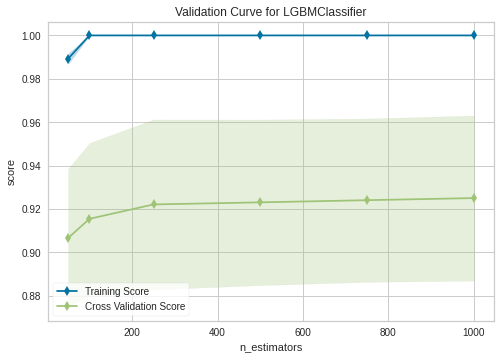

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b601d1250>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='n_estimators',
                param_range=array([  50,  100,  250,  500,  750, 1000]),
                scoring='f1')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="n_estimators", n_jobs=-1,
      param_range=[50,100,250,500,750,1000], cv=10, scoring="f1"))

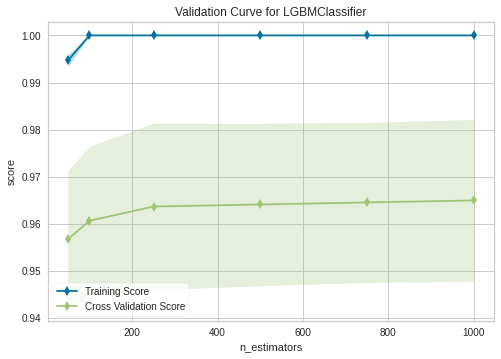

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5e2c1ad0>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='n_estimators',
                param_range=array([  50,  100,  250,  500,  750, 1000]),
                scoring='accuracy')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="n_estimators", n_jobs=-1,
      param_range=[50,100,250,500,750,1000], cv=10, scoring="accuracy"))

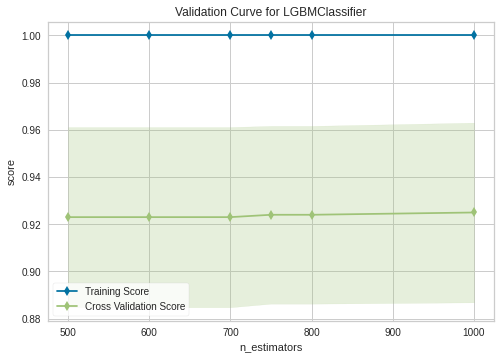

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5e3ad150>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='n_estimators',
                param_range=array([ 500,  600,  700,  750,  800, 1000]),
                scoring='f1')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="n_estimators", n_jobs=-1,
      param_range=[500,600,700,750,800,1000], cv=10, scoring="f1"))

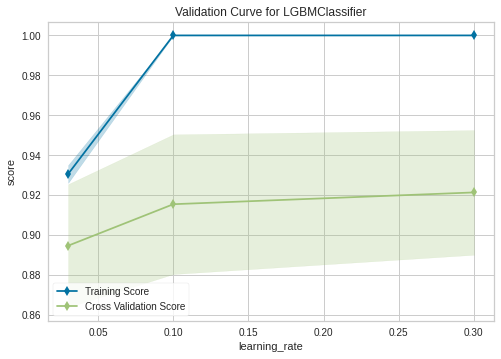

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b60168390>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='learning_rate',
                param_range=array([0.3 , 0.1 , 0.03]), scoring='f1')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="learning_rate", n_jobs=-1,
      param_range=[0.3, 0.1, 0.03], cv=10, scoring="f1"))

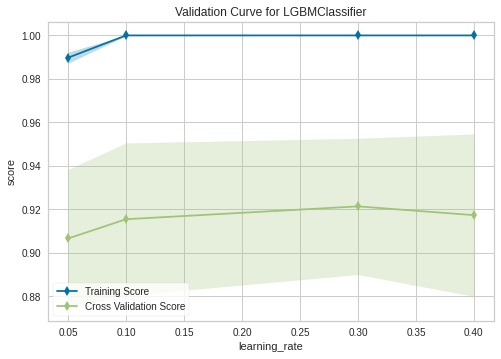

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b602d6590>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='learning_rate',
                param_range=array([0.4 , 0.3 , 0.1 , 0.05]), scoring='f1')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="learning_rate", n_jobs=-1,
      param_range=[0.4, 0.3, 0.1, 0.05], cv=10, scoring="f1"))

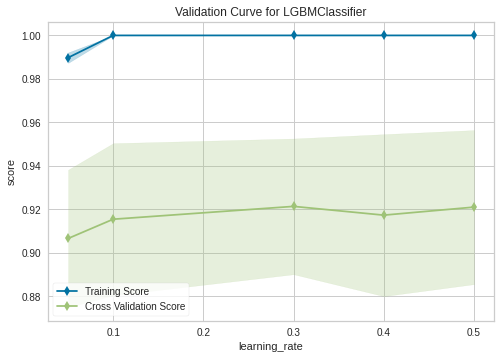

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b602ecd90>,
                cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                param_name='learning_rate',
                param_range=array([0.5 , 0.4 , 0.3 , 0.1 , 0.05]),
                scoring='f1')


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
print(validation_curve(LGBMClassifier(), X, y, param_name="learning_rate", n_jobs=-1,
      param_range=[0.5,0.4, 0.3, 0.1, 0.05], cv=10, scoring="f1"))

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.6)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       341
           1       0.96      0.84      0.90       215

    accuracy                           0.92       556
   macro avg       0.93      0.91      0.92       556
weighted avg       0.93      0.92      0.92       556

accuracy: - 0.924, f1 score: - 0.896, roc_score: - 0.909, precision: - 0.958, recall: - 0.842


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=1, k_neighbors=9)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       352
           1       0.97      0.88      0.93       343

    accuracy                           0.93       695
   macro avg       0.93      0.93      0.93       695
weighted avg       0.93      0.93      0.93       695

accuracy: - 0.929, f1 score: - 0.925, roc_score: - 0.929, precision: - 0.971, recall: - 0.883


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=1)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       352
           1       0.98      0.90      0.94       343

    accuracy                           0.94       695
   macro avg       0.95      0.94      0.94       695
weighted avg       0.95      0.94      0.94       695

accuracy: - 0.942, f1 score: - 0.939, roc_score: - 0.942, precision: - 0.984, recall: - 0.898


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.8, k_neighbors=11)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       336
           1       1.00      0.90      0.95       290

    accuracy                           0.95       626
   macro avg       0.96      0.95      0.95       626
weighted avg       0.96      0.95      0.95       626

accuracy: - 0.952, f1 score: - 0.946, roc_score: - 0.949, precision: - 0.996, recall: - 0.900


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.8, k_neighbors=11)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)

param_grid = {"max_depth":[2, 6, 12],
              "learning_rate":[0.3, 0.1, 0.03],
              "n_estimators":[50,100,500,1000]}

xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=10, n_jobs=-1, verbose = True)
# fitting the model for grid search
xgb_grid.fit(x_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.1, 0.03],
                         'max_depth': [2, 6, 12],
                         'n_estimators': [50, 100, 500, 1000]},
             verbose=True)

In [ ]:
print(xgb_grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 500}


In [ ]:
y_pred=xgb_grid.predict(x_test)

print(classification_report(y_test, y_pred))
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       336
           1       0.99      0.93      0.96       290

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626

accuracy: - 0.962, f1 score: - 0.957, roc_score: - 0.960, precision: - 0.985, recall: - 0.931


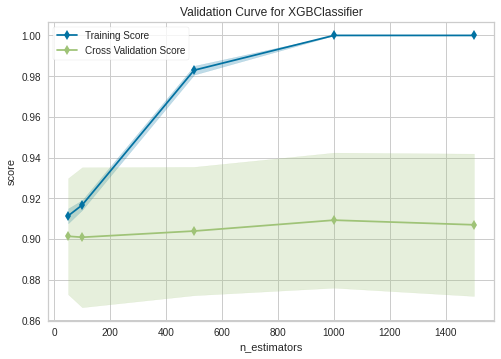

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b608ce090>,
                cv=10, estimator=XGBClassifier(), n_jobs=-1,
                param_name='n_estimators',
                param_range=array([  50,  100,  500, 1000, 1500]),
                scoring='f1')


In [ ]:
xgb = XGBClassifier()
print(validation_curve(xgb, X, y, param_name="n_estimators", n_jobs=-1,
      param_range=[50,100,500,1000,1500], cv=10, scoring="f1"))

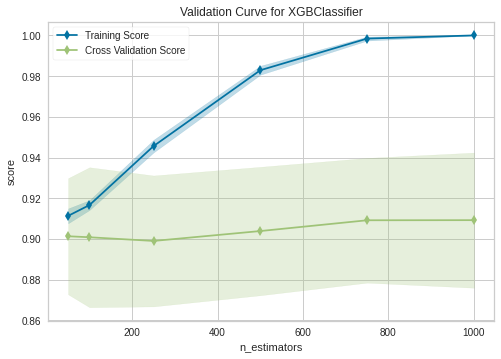

ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b61476990>,
                cv=10, estimator=XGBClassifier(), n_jobs=-1,
                param_name='n_estimators',
                param_range=array([  50,  100,  250,  500,  750, 1000]),
                scoring='f1')


In [ ]:
xgb = XGBClassifier()
print(validation_curve(xgb, X, y, param_name="n_estimators", n_jobs=-1,
      param_range=[50,100,250,500,750,1000], cv=10, scoring="f1"))

In [ ]:
df2.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,5.0,4.35,2.0,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,5.0,3.24,3.0,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,4.0,1.81,5.0,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,4.0,3.08,1.0,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,5.0,2.62,0.0,0,60.09,274.0,479.3


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.6)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
model_1 = LGBMClassifier()
model_2 = XGBClassifier()
model_3 = HistGradientBoostingClassifier()

# Making the final model using voting classifier
final_model = VotingClassifier(
  estimators=[('lgbm', model_1), ('xgb', model_2), ('hist', model_3)], voting='hard')
final_model.fit(x_train, y_train)
#Predict test data set.
y_pred = final_model.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       341
           1       0.97      0.89      0.93       215

    accuracy                           0.95       556
   macro avg       0.95      0.94      0.94       556
weighted avg       0.95      0.95      0.95       556

accuracy: - 0.948, f1 score: - 0.929, roc_score: - 0.937, precision: - 0.974, recall: - 0.888


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.6)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
model_1 = LGBMClassifier()
model_2 = XGBClassifier()
model_3 = HistGradientBoostingClassifier()

# Making the final model using voting classifier
final_model = VotingClassifier(
  estimators=[('lgbm', model_1), ('xgb', model_2), ('hist', model_3)], voting='hard')
final_model.fit(x_train, y_train)
#Predict test data set.
y_pred = final_model.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       341
           1       0.97      0.90      0.93       215

    accuracy                           0.95       556
   macro avg       0.96      0.94      0.95       556
weighted avg       0.95      0.95      0.95       556

accuracy: - 0.951, f1 score: - 0.935, roc_score: - 0.942, precision: - 0.970, recall: - 0.902


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.8)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
knn = KNeighborsClassifier()   #BEST
knn.fit(x_train, y_train)
#Predict test data set.
y_pred = knn.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       336
           1       0.85      0.93      0.89       290

    accuracy                           0.89       626
   macro avg       0.89      0.89      0.89       626
weighted avg       0.89      0.89      0.89       626

accuracy: - 0.891, f1 score: - 0.888, roc_score: - 0.894, precision: - 0.851, recall: - 0.928


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.8)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)


param_grid = {'n_neighbors': [5, 15, 25, 35, 45, 55, 65, 75]}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs=-1, scoring='f1', verbose = True)
# fitting the model for grid search
knn_grid.fit(x_train, y_train)
print(knn_grid.best_params_)
# knn.fit(x_train, y_train)
#Predict test data set.
y_pred = knn_grid.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       336
           1       0.85      0.95      0.90       290

    accuracy                           0.90       626
   macro avg       0.90      0.90      0.90       626
weighted avg       0.90      0.90      0.90       626

accuracy: - 0.898, f1 score: - 0.896, roc_score: - 0.901, precision: - 0.847, recall: - 0.952


In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.5)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
svc = SVC()   #BEST
svc.fit(x_train, y_train)
#Predict test data set.
y_pred = svc.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       349
           1       0.84      0.77      0.81       172

    accuracy                           0.88       521
   macro avg       0.87      0.85      0.86       521
weighted avg       0.88      0.88      0.88       521

accuracy: - 0.877, f1 score: - 0.806, roc_score: - 0.851, precision: - 0.842, recall: - 0.773


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.5)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

svc_grid = GridSearchCV(SVC(), param_grid, cv=10, n_jobs=-1, scoring='f1', verbose = True)
# fitting the model for grid search
svc_grid.fit(x_train, y_train)
print(svc_grid.best_params_)
# svc.fit(x_train, y_train)
#Predict test data set.
y_pred = svc_grid.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f, precision: - %.3f, recall: - %.3f"
      %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred),precision_score(y_test, y_pred, average='binary'),recall_score(y_test, y_pred, average='binary')))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       349
           1       0.92      0.83      0.87       172

    accuracy                           0.92       521
   macro avg       0.92      0.89      0.90       521
weighted avg       0.92      0.92      0.92       521

accuracy: - 0.917, f1 score: - 0.869, roc_score: - 0.894, precision: - 0.916, recall: - 0.826


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

Text(0.5, 1.0, 'Precision-Recall Curves')

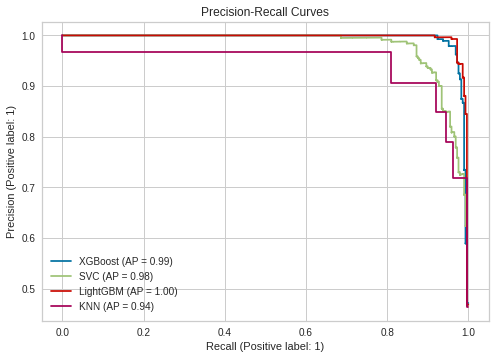

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.8)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)

xgb = XGBClassifier(learning_rate=0.3,max_depth=12,n_estimators=500)
xgb.fit(x_train,y_train)
svc = SVC(C=100,gamma=1,kernel='rbf')
svc.fit(x_train,y_train)
lgbm = LGBMClassifier(learning_rate=0.3,n_estimators=750)
lgbm.fit(x_train,y_train)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)


plot_precision_recall_curve(xgb, x_test, y_test, ax = plt.gca(),name = "XGBoost")

plot_precision_recall_curve(svc, x_test, y_test, ax = plt.gca(),name = "SVC")

plot_precision_recall_curve(lgbm, x_test, y_test, ax = plt.gca(),name = "LightGBM")

plot_precision_recall_curve(knn, x_test, y_test, ax = plt.gca(),name = "KNN")

plt.title('Precision-Recall Curves')

In [ ]:
models = []
models.append(('LOG', LogisticRegression()))
models.append(('SVC', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('KN', KNeighborsClassifier()))
models.append(('XG', XGBClassifier()))
models.append(('LG',LGBMClassifier()))
models.append(('GBT',ensemble.GradientBoostingClassifier()))
models.append(('ADA',AdaBoostClassifier()))
models.append(('EXT',ExtraTreesClassifier()))
models.append(('BAG',BaggingClassifier()))
models.append(('HIST',HistGradientBoostingClassifier()))


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']

In [ ]:
names = []
scores = []
maes = []
# for name, model in models:
#     model.fit(xtrain, ytrain)
#     y_pred = model.predict(xtest)
#     scores.append(accuracy_score(ytest, y_pred))
#     maes.append(mae(ytest, y_pred))
#     names.append(name)
# tr_split = pd.DataFrame({'Name': names, 'Score': scores, 'MAE': maes})
# print(tr_split)
scorer = make_scorer(f1)
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(model, X, y, cv=kfold, scoring=scorer).mean()

    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

In [ ]:
kf_cross_val

,Name,Score
0,Log,0.350097
1,SVC,0.000000
2,DT,0.874739
3,RF,0.910667
4,KN,0.540074
5,XG,0.900368
6,LG,0.922259
7,GBT,0.903301


In [ ]:
df2.columns

Index(['account_length', 'intertiol_plan', 'voice_mail_plan',
       'number_vm_messages', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'Churn', 'total_charge',
       'total_calls', 'total_min'],
      dtype='object')

In [ ]:
scaler = MinMaxScaler()
# transform data
minscaled = df2.copy(deep=True)
cols = ['account_length',
       'number_vm_messages', 'total_min', 'total_calls',
       'total_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls',]
minscaled[cols] = scaler.fit_transform(minscaled[cols])
# stdscaled = scaler.fit_transform(x)
minscaled.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,0.060606,0,0,0.000000,0.879781,0.25,0.880567,0.222222,0,0.396219,0.303483,0.493601
1,0.450216,0,0,0.000000,0.655738,0.25,0.655870,0.333333,0,0.657013,0.203980,0.634369
2,0.415584,0,1,0.627451,0.366120,0.20,0.366397,0.555556,0,0.579646,0.318408,0.632874
3,0.519481,0,1,0.686275,0.622951,0.20,0.623482,0.111111,0,0.246179,0.089552,0.332558
4,0.419913,0,1,0.431373,0.530055,0.25,0.530364,0.000000,0,0.537812,0.427861,0.339206


In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
names = []
scores = []
maes = []
# for name, model in models:
#     model.fit(xtrain, ytrain)
#     y_pred = model.predict(xtest)
#     scores.append(accuracy_score(ytest, y_pred))
#     maes.append(mae(ytest, y_pred))
#     names.append(name)
# tr_split = pd.DataFrame({'Name': names, 'Score': scores, 'MAE': maes})
# print(tr_split)
scorer = make_scorer(f1)
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(model, X, y, cv=kfold, scoring=scorer).mean()

    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

    Name     Score
0    LOG  0.434557
1    SVC  0.725550
2     DT  0.877975
3     RF  0.916685
4     KN  0.764903
5     XG  0.900368
6     LG  0.920703
7    GBT  0.902296
8    ADA  0.722497
9    EXT  0.937780
10   BAG  0.908740
11  HIST  0.922756


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
names = []
scores = []
maes = []
# for name, model in models:
#     model.fit(xtrain, ytrain)
#     y_pred = model.predict(xtest)
#     scores.append(accuracy_score(ytest, y_pred))
#     maes.append(mae(ytest, y_pred))
#     names.append(name)
# tr_split = pd.DataFrame({'Name': names, 'Score': scores, 'MAE': maes})
# print(tr_split)
scorer = make_scorer(f1)
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(model, X, y, cv=kfold, scoring=scorer).mean()

    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


    Name     Score
0    LOG  0.350097
1    SVC  0.000000
2     DT  0.880567
3     RF  0.914410
4     KN  0.540074
5     XG  0.900368
6     LG  0.922259
7    GBT  0.902296
8    ADA  0.722497
9    EXT  0.937361
10   BAG  0.907669
11  HIST  0.922191


In [ ]:
#Create KNN Object.
xgb = XGBClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928


# LGBM

In [ ]:
#Create KNN Object.
lgbm = LGBMClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lgbm.fit(x_train, y_train)
#Predict test data set.
y_pred = lgbm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

NameError: ignored

In [ ]:
lgbm = LGBMClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lgbm.fit(x_train, y_train)
#Predict test data set.
y_pred = lgbm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

NameError: ignored

In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = LGBMClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.7, k_neighbors=11)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
lbgm = LGBMClassifier()   #BEST
lbgm.fit(x_train, y_train)
#Predict test data set.
y_pred = lbgm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = lbgm.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred30.csv', index=False)
files.download('pred30.csv')

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
print(y.value_counts())
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)
x_over, y_over = over.fit_resample(X, y)
print(y_over.value_counts())
x_balanced, y_balanced = under.fit_resample(x_over, y_over)
print(y_balanced.value_counts())
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=3)
lbgm = LGBMClassifier()
lbgm.fit(x_train, y_train)
#Predict test data set.
y_pred = lbgm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = LGBMClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.6, k_neighbors=11)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=3)
lbgm = LGBMClassifier()
lbgm.fit(x_train, y_train)
#Predict test data set.
y_pred = lbgm.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

# Extra Trees Classifier

In [ ]:
#Create KNN Object.
extra = ExtraTreesClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
extra.fit(x_train, y_train)
#Predict test data set.
y_pred = extra.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       348
           1       0.97      0.90      0.93       115

    accuracy                           0.97       463
   macro avg       0.97      0.94      0.96       463
weighted avg       0.97      0.97      0.97       463

accuracy: - 0.968, f1 score: - 0.932, roc_score: - 0.944


In [ ]:
extra = ExtraTreesClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
extra.fit(x_train, y_train)
#Predict test data set.
y_pred = extra.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       348
           1       0.97      0.89      0.93       115

    accuracy                           0.97       463
   macro avg       0.97      0.94      0.95       463
weighted avg       0.97      0.97      0.96       463

accuracy: - 0.965, f1 score: - 0.927, roc_score: - 0.939


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = ExtraTreesClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=3, ratio=0.5, Mean ROC AUC: 0.989
> k=3, ratio=0.6, Mean ROC AUC: 0.988
> k=3, ratio=0.7, Mean ROC AUC: 0.988
> k=3, ratio=0.8, Mean ROC AUC: 0.988
> k=3, ratio=0.9, Mean ROC AUC: 0.988
> k=3, ratio=1.0, Mean ROC AUC: 0.988
> k=5, ratio=0.5, Mean ROC AUC: 0.989
> k=5, ratio=0.6, Mean ROC AUC: 0.988
> k=5, ratio=0.7, Mean ROC AUC: 0.987
> k=5, ratio=0.8, Mean ROC AUC: 0.988
> k=5, ratio=0.9, Mean ROC AUC: 0.988
> k=5, ratio=1.0, Mean ROC AUC: 0.987
> k=7, ratio=0.5, Mean ROC AUC: 0.988
> k=7, ratio=0.6, Mean ROC AUC: 0.988
> k=7, ratio=0.7, Mean ROC AUC: 0.988
> k=7, ratio=0.8, Mean ROC AUC: 0.987
> k=7, ratio=0.9, Mean ROC AUC: 0.987
> k=7, ratio=1.0, Mean ROC AUC: 0.987
> k=9, ratio=0.5, Mean ROC AUC: 0.988
> k=9, ratio=0.6, Mean ROC AUC: 0.988
> k=9, ratio=0.7, Mean ROC AUC: 0.988
> k=9, ratio=0.8, Mean ROC AUC: 0.987
> k=9, ratio=0.9, Mean ROC AUC: 0.987
> k=9, ratio=1.0, Mean ROC AUC: 0.987
> k=11, ratio=0.5, Mean ROC AUC: 0.987
> k=11, ratio=0.6, Mean ROC AUC: 0.989
> k=11, ra

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.6, k_neighbors=11)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
extra = ExtraTreesClassifier()
extra.fit(x_train, y_train)
#Predict test data set.
y_pred = extra.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       341
           1       0.97      0.86      0.91       215

    accuracy                           0.94       556
   macro avg       0.95      0.92      0.93       556
weighted avg       0.94      0.94      0.94       556

accuracy: - 0.937, f1 score: - 0.914, roc_score: - 0.923


In [ ]:
X = minscaled.drop(['Churn'],axis=1)
y = minscaled['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = ExtraTreesClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=3, ratio=0.5, Mean ROC AUC: 0.989
> k=3, ratio=0.6, Mean ROC AUC: 0.988
> k=3, ratio=0.7, Mean ROC AUC: 0.989
> k=3, ratio=0.8, Mean ROC AUC: 0.989
> k=3, ratio=0.9, Mean ROC AUC: 0.988
> k=3, ratio=1.0, Mean ROC AUC: 0.987
> k=5, ratio=0.5, Mean ROC AUC: 0.989
> k=5, ratio=0.6, Mean ROC AUC: 0.989
> k=5, ratio=0.7, Mean ROC AUC: 0.988
> k=5, ratio=0.8, Mean ROC AUC: 0.988
> k=5, ratio=0.9, Mean ROC AUC: 0.988
> k=5, ratio=1.0, Mean ROC AUC: 0.987
> k=7, ratio=0.5, Mean ROC AUC: 0.988
> k=7, ratio=0.6, Mean ROC AUC: 0.989
> k=7, ratio=0.7, Mean ROC AUC: 0.988
> k=7, ratio=0.8, Mean ROC AUC: 0.987
> k=7, ratio=0.9, Mean ROC AUC: 0.988
> k=7, ratio=1.0, Mean ROC AUC: 0.987
> k=9, ratio=0.5, Mean ROC AUC: 0.988
> k=9, ratio=0.6, Mean ROC AUC: 0.988
> k=9, ratio=0.7, Mean ROC AUC: 0.988
> k=9, ratio=0.8, Mean ROC AUC: 0.988
> k=9, ratio=0.9, Mean ROC AUC: 0.988
> k=9, ratio=1.0, Mean ROC AUC: 0.987
> k=11, ratio=0.5, Mean ROC AUC: 0.988
> k=11, ratio=0.6, Mean ROC AUC: 0.987
> k=11, ra

In [ ]:
X = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
oversample = SMOTE(sampling_strategy=0.6, k_neighbors=7) #BEST
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=3)
extra = ExtraTreesClassifier()
extra.fit(x_train, y_train)
#Predict test data set.
y_pred = extra.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       345
           1       0.95      0.96      0.96       211

    accuracy                           0.97       556
   macro avg       0.96      0.97      0.97       556
weighted avg       0.97      0.97      0.97       556

accuracy: - 0.968, f1 score: - 0.958, roc_score: - 0.967


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)

scaler = MinMaxScaler()
# transform data
# minscaled = df2.copy(deep=True)
cols = ['account_length',
       'number_vm_messages', 'total_min', 'total_calls',
       'total_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls',]
testx[cols] = scaler.fit_transform(testx[cols])

predtest = extra.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred31.csv', index=False)
files.download('pred31.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Bagging Classifier

In [ ]:
bagmodel = BaggingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
bagmodel.fit(x_train, y_train)
#Predict test data set.
y_pred = bagmodel.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       348
           1       0.95      0.85      0.90       115

    accuracy                           0.95       463
   macro avg       0.95      0.92      0.93       463
weighted avg       0.95      0.95      0.95       463

accuracy: - 0.952, f1 score: - 0.899, roc_score: - 0.919


In [ ]:
bag = BaggingClassifier()
#Create x and y variables.
x = minscaled.drop(columns=['Churn'])
y = minscaled['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
bag.fit(x_train, y_train)
#Predict test data set.
y_pred = bag.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       348
           1       0.93      0.86      0.90       115

    accuracy                           0.95       463
   macro avg       0.94      0.92      0.93       463
weighted avg       0.95      0.95      0.95       463

accuracy: - 0.950, f1 score: - 0.896, roc_score: - 0.920


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [7,55,105,155,207]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = BaggingClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=7, ratio=0.5, Mean ROC AUC: 0.974
> k=7, ratio=0.6, Mean ROC AUC: 0.969
> k=7, ratio=0.7, Mean ROC AUC: 0.972
> k=7, ratio=0.8, Mean ROC AUC: 0.973
> k=7, ratio=0.9, Mean ROC AUC: 0.971
> k=7, ratio=1.0, Mean ROC AUC: 0.969
> k=55, ratio=0.5, Mean ROC AUC: 0.970
> k=55, ratio=0.6, Mean ROC AUC: 0.973
> k=55, ratio=0.7, Mean ROC AUC: 0.972
> k=55, ratio=0.8, Mean ROC AUC: 0.973
> k=55, ratio=0.9, Mean ROC AUC: 0.970
> k=55, ratio=1.0, Mean ROC AUC: 0.972
> k=105, ratio=0.5, Mean ROC AUC: 0.970
> k=105, ratio=0.6, Mean ROC AUC: 0.972
> k=105, ratio=0.7, Mean ROC AUC: 0.973
> k=105, ratio=0.8, Mean ROC AUC: 0.973
> k=105, ratio=0.9, Mean ROC AUC: 0.969
> k=105, ratio=1.0, Mean ROC AUC: 0.970
> k=155, ratio=0.5, Mean ROC AUC: 0.969
> k=155, ratio=0.6, Mean ROC AUC: 0.970
> k=155, ratio=0.7, Mean ROC AUC: 0.972
> k=155, ratio=0.8, Mean ROC AUC: 0.972
> k=155, ratio=0.9, Mean ROC AUC: 0.972
> k=155, ratio=1.0, Mean ROC AUC: 0.972
> k=207, ratio=0.5, Mean ROC AUC: 0.973
> k=207, ratio=0.6

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.6, k_neighbors=55)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
bag1 = BaggingClassifier()
bag1.fit(x_train, y_train)
#Predict test data set.
y_pred = bag1.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       341
           1       0.95      0.86      0.90       215

    accuracy                           0.93       556
   macro avg       0.93      0.92      0.92       556
weighted avg       0.93      0.93      0.93       556

accuracy: - 0.928, f1 score: - 0.902, roc_score: - 0.916


In [ ]:
bag = BaggingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn','number_vm_messages'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
bag.fit(x_train, y_train)
#Predict test data set.
y_pred = bag.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       348
           1       0.93      0.86      0.90       115

    accuracy                           0.95       463
   macro avg       0.94      0.92      0.93       463
weighted avg       0.95      0.95      0.95       463

accuracy: - 0.950, f1 score: - 0.896, roc_score: - 0.920


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)

bag2 = BaggingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
bag2.fit(x, y)

predtest = bag2.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred32.csv', index=False)
files.download('pred32.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# HistGradientBoostingClassifier

In [ ]:
hist = HistGradientBoostingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
hist.fit(x_train, y_train)
#Predict test data set.
y_pred = hist.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       348
           1       0.99      0.84      0.91       115

    accuracy                           0.96       463
   macro avg       0.97      0.92      0.94       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.959, f1 score: - 0.911, roc_score: - 0.920


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [7,55,105,155,207]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = HistGradientBoostingClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=7, ratio=0.5, Mean ROC AUC: 0.980
> k=7, ratio=0.6, Mean ROC AUC: 0.979
> k=7, ratio=0.7, Mean ROC AUC: 0.980
> k=7, ratio=0.8, Mean ROC AUC: 0.981
> k=7, ratio=0.9, Mean ROC AUC: 0.981
> k=7, ratio=1.0, Mean ROC AUC: 0.981
> k=55, ratio=0.5, Mean ROC AUC: 0.979
> k=55, ratio=0.6, Mean ROC AUC: 0.980
> k=55, ratio=0.7, Mean ROC AUC: 0.981
> k=55, ratio=0.8, Mean ROC AUC: 0.981
> k=55, ratio=0.9, Mean ROC AUC: 0.980
> k=55, ratio=1.0, Mean ROC AUC: 0.981
> k=105, ratio=0.5, Mean ROC AUC: 0.979
> k=105, ratio=0.6, Mean ROC AUC: 0.981
> k=105, ratio=0.7, Mean ROC AUC: 0.981
> k=105, ratio=0.8, Mean ROC AUC: 0.981
> k=105, ratio=0.9, Mean ROC AUC: 0.981
> k=105, ratio=1.0, Mean ROC AUC: 0.982
> k=155, ratio=0.5, Mean ROC AUC: 0.979
> k=155, ratio=0.6, Mean ROC AUC: 0.979
> k=155, ratio=0.7, Mean ROC AUC: 0.981
> k=155, ratio=0.8, Mean ROC AUC: 0.981
> k=155, ratio=0.9, Mean ROC AUC: 0.982
> k=155, ratio=1.0, Mean ROC AUC: 0.981
> k=207, ratio=0.5, Mean ROC AUC: 0.980
> k=207, ratio=0.6

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.9, k_neighbors=155)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
hist1 = HistGradientBoostingClassifier()
hist1.fit(x_train, y_train)
#Predict test data set.
y_pred = hist1.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       340
           1       0.99      0.92      0.96       320

    accuracy                           0.96       660
   macro avg       0.96      0.96      0.96       660
weighted avg       0.96      0.96      0.96       660

accuracy: - 0.959, f1 score: - 0.956, roc_score: - 0.958


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)

predtest = hist1.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred33.csv', index=False)
files.download('pred33.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
gbc.fit(x_train, y_train)
#Predict test data set.
y_pred = gbc.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.97      0.86      0.91       115

    accuracy                           0.96       463
   macro avg       0.96      0.93      0.94       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.959, f1 score: - 0.912, roc_score: - 0.926


In [ ]:
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [7,55,105,155,207]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = GradientBoostingClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=7, ratio=0.5, Mean ROC AUC: 0.956
> k=7, ratio=0.6, Mean ROC AUC: 0.955
> k=7, ratio=0.7, Mean ROC AUC: 0.954
> k=7, ratio=0.8, Mean ROC AUC: 0.952
> k=7, ratio=0.9, Mean ROC AUC: 0.953
> k=7, ratio=1.0, Mean ROC AUC: 0.953
> k=55, ratio=0.5, Mean ROC AUC: 0.958
> k=55, ratio=0.6, Mean ROC AUC: 0.956
> k=55, ratio=0.7, Mean ROC AUC: 0.952
> k=55, ratio=0.8, Mean ROC AUC: 0.955
> k=55, ratio=0.9, Mean ROC AUC: 0.956
> k=55, ratio=1.0, Mean ROC AUC: 0.952
> k=105, ratio=0.5, Mean ROC AUC: 0.956
> k=105, ratio=0.6, Mean ROC AUC: 0.955
> k=105, ratio=0.7, Mean ROC AUC: 0.954
> k=105, ratio=0.8, Mean ROC AUC: 0.954
> k=105, ratio=0.9, Mean ROC AUC: 0.952
> k=105, ratio=1.0, Mean ROC AUC: 0.952
> k=155, ratio=0.5, Mean ROC AUC: 0.956
> k=155, ratio=0.6, Mean ROC AUC: 0.956
> k=155, ratio=0.7, Mean ROC AUC: 0.956
> k=155, ratio=0.8, Mean ROC AUC: 0.953
> k=155, ratio=0.9, Mean ROC AUC: 0.951
> k=155, ratio=1.0, Mean ROC AUC: 0.950
> k=207, ratio=0.5, Mean ROC AUC: 0.954
> k=207, ratio=0.6

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.5, k_neighbors=55)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
gbc1 = GradientBoostingClassifier()
gbc1.fit(x_train, y_train)
#Predict test data set.
y_pred = gbc1.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       349
           1       0.97      0.78      0.87       172

    accuracy                           0.92       521
   macro avg       0.94      0.89      0.91       521
weighted avg       0.93      0.92      0.92       521

accuracy: - 0.921, f1 score: - 0.868, roc_score: - 0.887


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)

gbc2 = GradientBoostingClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
gbc2.fit(x, y)

predtest = gbc2.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred34.csv', index=False)
files.download('pred34.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing Oversampling and Undersampling Ratios

In [ ]:
# oversample = SMOTE()
X = df2.drop(columns=['Churn'])
y = df2['Churn']
print(y.value_counts())
under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X, y)
print(y.value_counts())

0    1737
1     575
Name: Churn, dtype: int64
0    1150
1     575
Name: Churn, dtype: int64


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
print(y.value_counts())
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
print(y.value_counts())

0    1737
1     575
Name: Churn, dtype: int64
0    1736
1     868
Name: Churn, dtype: int64


In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
print(y.value_counts())
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
print(y.value_counts())

0    1737
1     575
Name: Churn, dtype: int64
0    1446
1     868
Name: Churn, dtype: int64


# Trying a New Feature Aggregation

In [ ]:
df5 = df.copy(deep=True)
df5['total_charge'] = df5['total_day_charge'] + df5['total_eve_charge'] + df5['total_night_charge'] + df5['total_intl_charge']
df5['total_calls'] = df5['total_day_calls'] + df5['total_eve_calls'] + df5['total_night_calls'] + df5['total_intl_calls']
df5['total_min'] = df5['total_day_min'] + df5['total_eve_min'] + df5['total_night_minutes'] + df5['total_intl_minutes']
df5.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,1001,15.0,2,0,0,0.0,121.1,130.0,20.59,216.0,...,33.0,10.58,16.1,5.0,4.35,2.0,0,53.88,254.0,588.3
1,1002,105.0,2,0,0,0.0,259.3,96.0,44.08,175.2,...,36.0,10.01,12.0,5.0,3.24,3.0,0,72.22,234.0,668.9
2,1003,97.0,2,0,1,32.0,183.4,94.0,31.18,269.1,...,38.0,9.16,6.7,4.0,1.81,5.0,0,65.02,256.0,662.7
3,1004,121.0,1,0,1,35.0,68.7,95.0,11.68,209.2,...,42.0,8.88,11.4,4.0,3.08,1.0,0,41.42,210.0,486.7
4,1005,98.0,2,0,1,22.0,278.3,89.0,47.31,93.4,...,42.0,4.84,9.7,5.0,2.62,0.0,0,62.71,279.0,489.0


In [ ]:
df5.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_intl_calls', 'total_intl_charge', 'total_intl_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
df5.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,2.0,0,53.88,254.0,588.3
1,105.0,0,0,0.0,3.0,0,72.22,234.0,668.9
2,97.0,0,1,32.0,5.0,0,65.02,256.0,662.7
3,121.0,0,1,35.0,1.0,0,41.42,210.0,486.7
4,98.0,0,1,22.0,0.0,0,62.71,279.0,489.0


In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
#Create x and y variables.
x = df5.drop(columns=['Churn'])
y = df5['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       348
           1       0.95      0.81      0.87       115

    accuracy                           0.94       463
   macro avg       0.94      0.90      0.92       463
weighted avg       0.94      0.94      0.94       463

accuracy: - 0.942, f1 score: - 0.873, roc_score: - 0.897


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge'] + testx['total_intl_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls'] + testx['total_intl_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes'] + testx['total_intl_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_intl_calls', 'total_intl_charge', 'total_intl_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = xgb.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred35.csv', index=False)
files.download('pred35.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

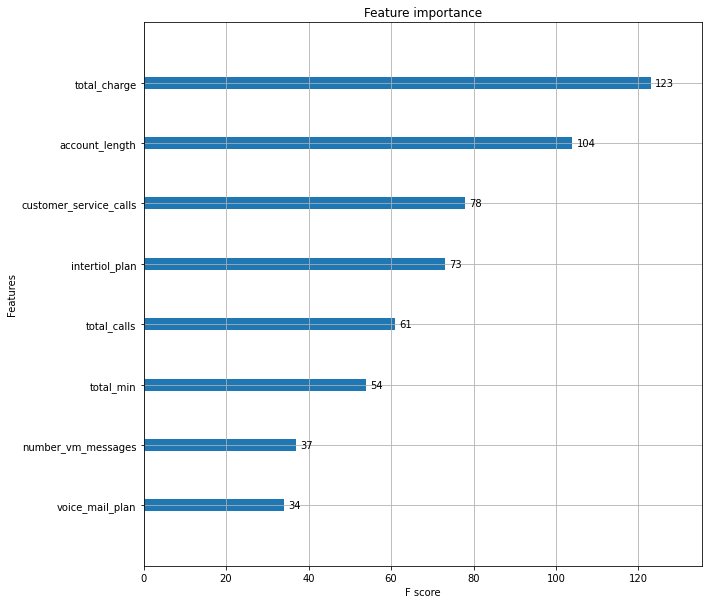

In [ ]:
ax = plot_importance(xgb)
fig = ax.figure
fig.set_size_inches(10,10)

In [ ]:
X = df5.drop(['Churn'],axis=1)
y = df5['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = XGBClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=3, ratio=0.5, Mean ROC AUC: 0.948
> k=3, ratio=0.6, Mean ROC AUC: 0.947
> k=3, ratio=0.7, Mean ROC AUC: 0.949
> k=3, ratio=0.8, Mean ROC AUC: 0.945
> k=3, ratio=0.9, Mean ROC AUC: 0.946
> k=3, ratio=1.0, Mean ROC AUC: 0.946
> k=5, ratio=0.5, Mean ROC AUC: 0.947
> k=5, ratio=0.6, Mean ROC AUC: 0.948
> k=5, ratio=0.7, Mean ROC AUC: 0.946
> k=5, ratio=0.8, Mean ROC AUC: 0.947
> k=5, ratio=0.9, Mean ROC AUC: 0.947
> k=5, ratio=1.0, Mean ROC AUC: 0.946
> k=7, ratio=0.5, Mean ROC AUC: 0.950
> k=7, ratio=0.6, Mean ROC AUC: 0.948
> k=7, ratio=0.7, Mean ROC AUC: 0.948
> k=7, ratio=0.8, Mean ROC AUC: 0.946
> k=7, ratio=0.9, Mean ROC AUC: 0.946
> k=7, ratio=1.0, Mean ROC AUC: 0.946
> k=9, ratio=0.5, Mean ROC AUC: 0.950
> k=9, ratio=0.6, Mean ROC AUC: 0.947
> k=9, ratio=0.7, Mean ROC AUC: 0.949
> k=9, ratio=0.8, Mean ROC AUC: 0.948
> k=9, ratio=0.9, Mean ROC AUC: 0.945
> k=9, ratio=1.0, Mean ROC AUC: 0.947
> k=11, ratio=0.5, Mean ROC AUC: 0.949
> k=11, ratio=0.6, Mean ROC AUC: 0.949
> k=11, ra

In [ ]:
X = df5.drop(columns=['Churn'])
y = df5['Churn']
oversample = SMOTE(sampling_strategy=0.5, k_neighbors=9)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       349
           1       0.93      0.80      0.86       172

    accuracy                           0.91       521
   macro avg       0.92      0.88      0.90       521
weighted avg       0.91      0.91      0.91       521

accuracy: - 0.914, f1 score: - 0.859, roc_score: - 0.884


In [ ]:
xgb = XGBClassifier()
#Create x and y variables.
x = df5.drop(columns=['Churn','number_vm_messages'])
y = df5['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       348
           1       0.92      0.81      0.86       115

    accuracy                           0.94       463
   macro avg       0.93      0.89      0.91       463
weighted avg       0.93      0.94      0.93       463

accuracy: - 0.935, f1 score: - 0.861, roc_score: - 0.893


In [ ]:
df7 = df.copy(True)
df7.drop(['location_code', 'customer_id',
       'total_day_calls',
       'total_intl_calls',
       'total_eve_calls',
       'total_night_calls'],axis=1,inplace=True)
df7.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_charge,total_eve_min,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,customer_service_calls,Churn
0,15.0,0,0,0.0,121.1,20.59,216.0,18.36,235.1,10.58,16.1,4.35,2.0,0
1,105.0,0,0,0.0,259.3,44.08,175.2,14.89,222.4,10.01,12.0,3.24,3.0,0
2,97.0,0,1,32.0,183.4,31.18,269.1,22.87,203.5,9.16,6.7,1.81,5.0,0
3,121.0,0,1,35.0,68.7,11.68,209.2,17.78,197.4,8.88,11.4,3.08,1.0,0
4,98.0,0,1,22.0,278.3,47.31,93.4,7.94,107.6,4.84,9.7,2.62,0.0,0


In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
#Create x and y variables.
x = df7.drop(columns=['Churn'])
y = df7['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       348
           1       0.91      0.71      0.80       115

    accuracy                           0.91       463
   macro avg       0.91      0.85      0.87       463
weighted avg       0.91      0.91      0.91       463

accuracy: - 0.911, f1 score: - 0.800, roc_score: - 0.845


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

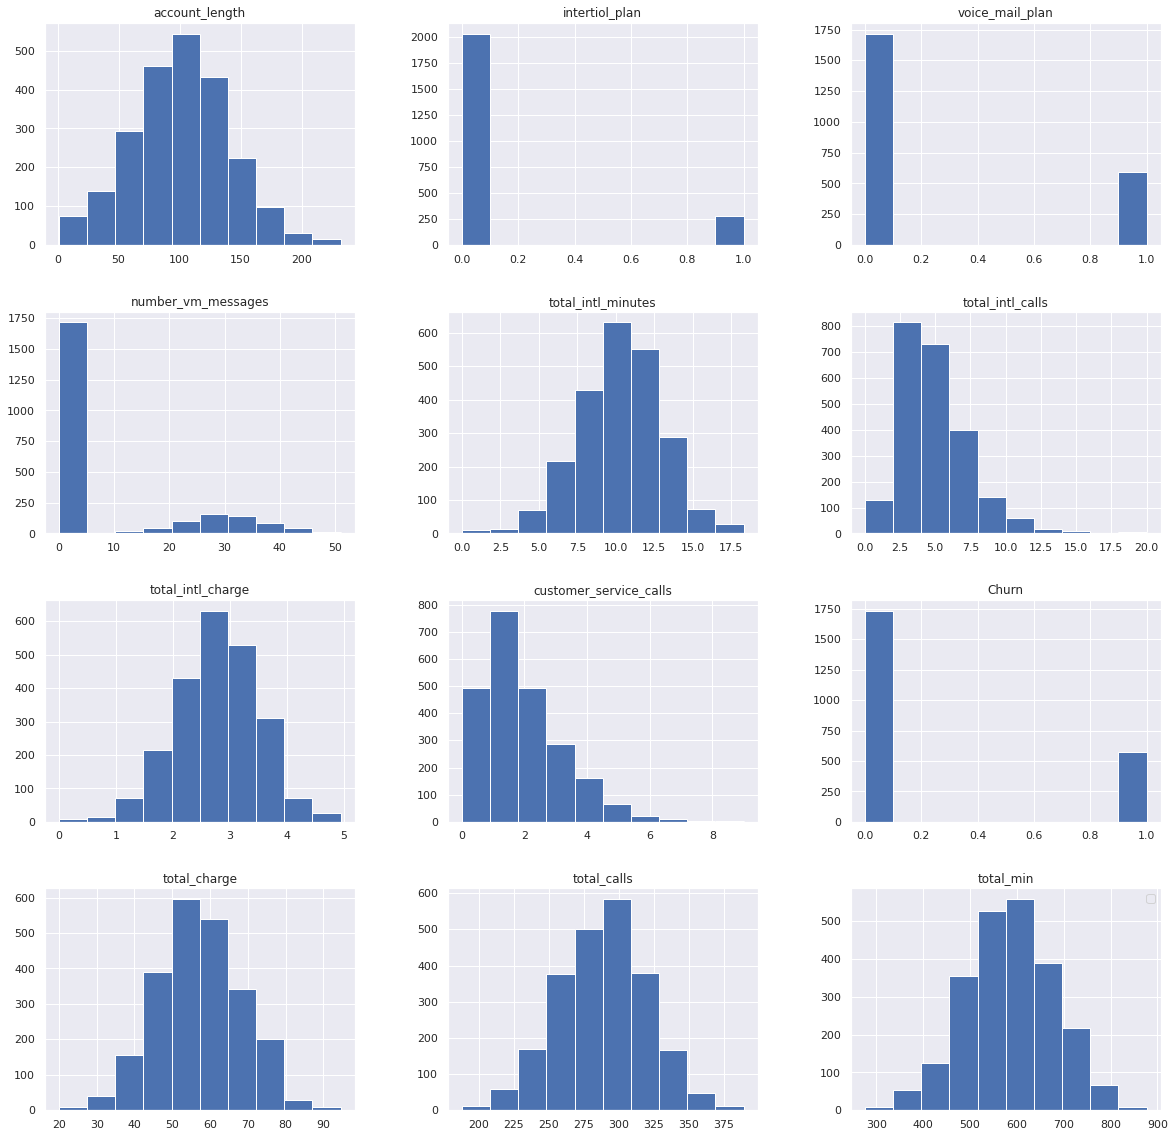

In [ ]:
sns.set()
plt.gcf().clear()
df2.hist(figsize = (20,20))
plt.xlabel('')
plt.legend()

In [ ]:
df7 = df2.copy(deep=True)
df7.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,5.0,4.35,2.0,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,5.0,3.24,3.0,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,4.0,1.81,5.0,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,4.0,3.08,1.0,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,5.0,2.62,0.0,0,60.09,274.0,479.3


In [ ]:
df7['total_intl_calls'] = np.log(df7['total_intl_calls']+1)
df7.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,1.791759,4.35,2.0,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,1.791759,3.24,3.0,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,1.609438,1.81,5.0,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,1.609438,3.08,1.0,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,1.791759,2.62,0.0,0,60.09,274.0,479.3


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

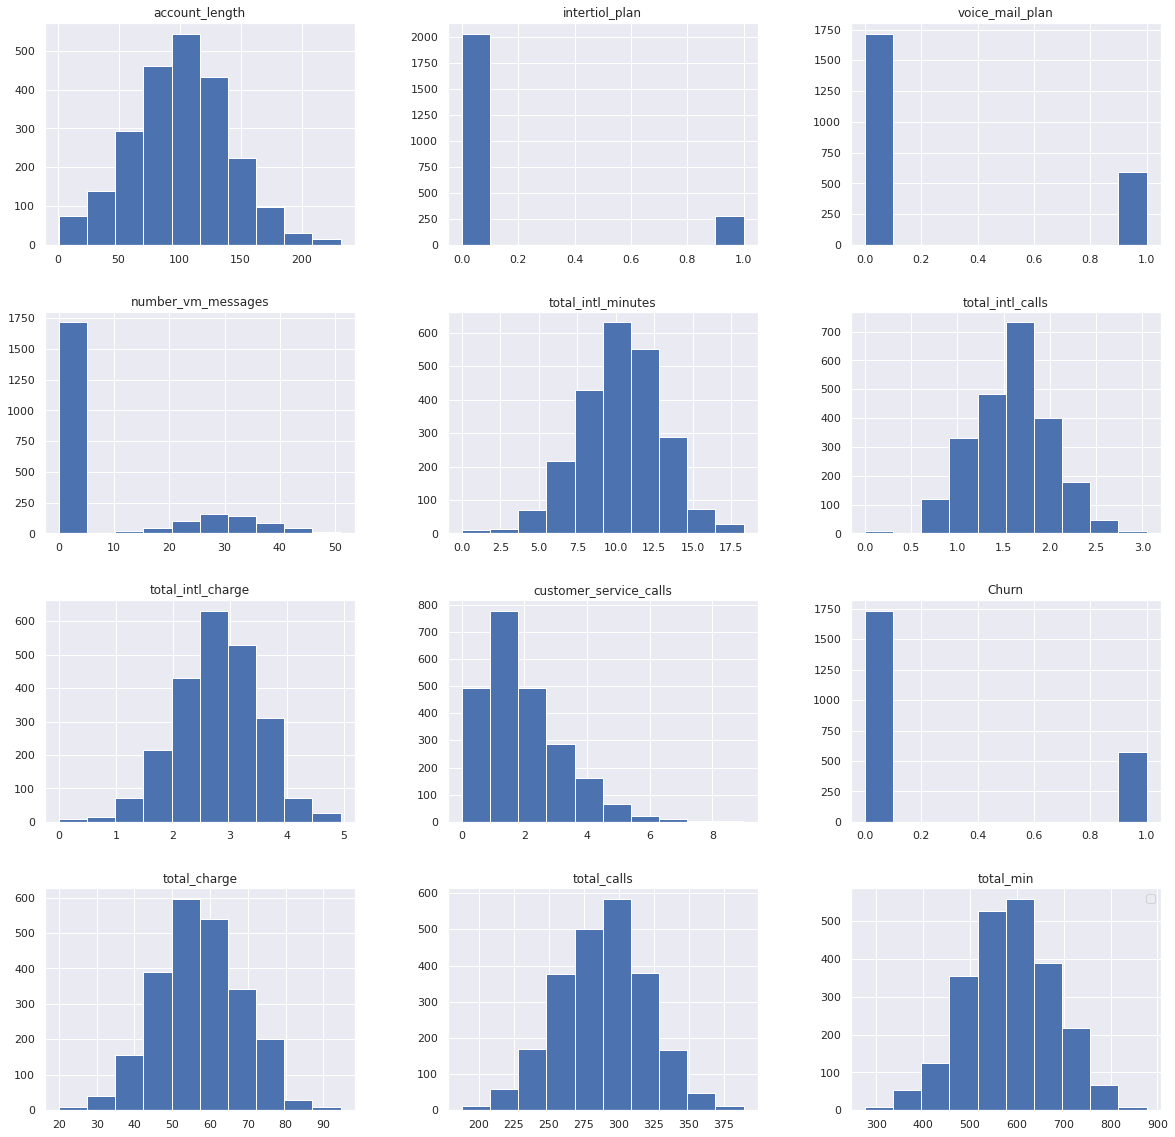

In [ ]:
sns.set()
plt.gcf().clear()
df7.hist(figsize = (20,20))
plt.xlabel('')
plt.legend()

In [ ]:
xgb = XGBClassifier(objective='binary:logistic')
#Create x and y variables.
x = df7.drop(columns=['Churn'])
y = df7['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928


In [ ]:
X = df7.drop(['Churn'],axis=1)
y = df7['Churn']
k_values = [3,5,7,9,11]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = XGBClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=3, ratio=0.5, Mean ROC AUC: 0.952
> k=3, ratio=0.6, Mean ROC AUC: 0.951
> k=3, ratio=0.7, Mean ROC AUC: 0.950
> k=3, ratio=0.8, Mean ROC AUC: 0.950
> k=3, ratio=0.9, Mean ROC AUC: 0.949
> k=3, ratio=1.0, Mean ROC AUC: 0.947
> k=5, ratio=0.5, Mean ROC AUC: 0.950
> k=5, ratio=0.6, Mean ROC AUC: 0.952
> k=5, ratio=0.7, Mean ROC AUC: 0.952
> k=5, ratio=0.8, Mean ROC AUC: 0.949
> k=5, ratio=0.9, Mean ROC AUC: 0.950
> k=5, ratio=1.0, Mean ROC AUC: 0.947
> k=7, ratio=0.5, Mean ROC AUC: 0.949
> k=7, ratio=0.6, Mean ROC AUC: 0.950
> k=7, ratio=0.7, Mean ROC AUC: 0.950
> k=7, ratio=0.8, Mean ROC AUC: 0.949
> k=7, ratio=0.9, Mean ROC AUC: 0.950
> k=7, ratio=1.0, Mean ROC AUC: 0.949
> k=9, ratio=0.5, Mean ROC AUC: 0.952
> k=9, ratio=0.6, Mean ROC AUC: 0.952
> k=9, ratio=0.7, Mean ROC AUC: 0.953
> k=9, ratio=0.8, Mean ROC AUC: 0.951
> k=9, ratio=0.9, Mean ROC AUC: 0.952
> k=9, ratio=1.0, Mean ROC AUC: 0.951
> k=11, ratio=0.5, Mean ROC AUC: 0.952
> k=11, ratio=0.6, Mean ROC AUC: 0.950
> k=11, ra

In [ ]:
X = df7.drop(columns=['Churn'])
y = df7['Churn']
oversample = SMOTE(sampling_strategy=0.7, k_neighbors=9)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=6)
xgb = XGBClassifier()   #BEST
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       345
           1       0.99      0.87      0.92       246

    accuracy                           0.94       591
   macro avg       0.95      0.93      0.94       591
weighted avg       0.94      0.94      0.94       591

accuracy: - 0.941, f1 score: - 0.924, roc_score: - 0.931


In [ ]:
df7 = df2.copy(deep=True)
df7['total_intl_calls'] = np.log(df7['total_intl_calls']+1)
df7['customer_service_calls'] = np.log(df7['customer_service_calls']+1)
df7.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,1.791759,4.35,1.098612,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,1.791759,3.24,1.386294,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,1.609438,1.81,1.791759,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,1.609438,3.08,0.693147,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,1.791759,2.62,0.000000,0,60.09,274.0,479.3


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

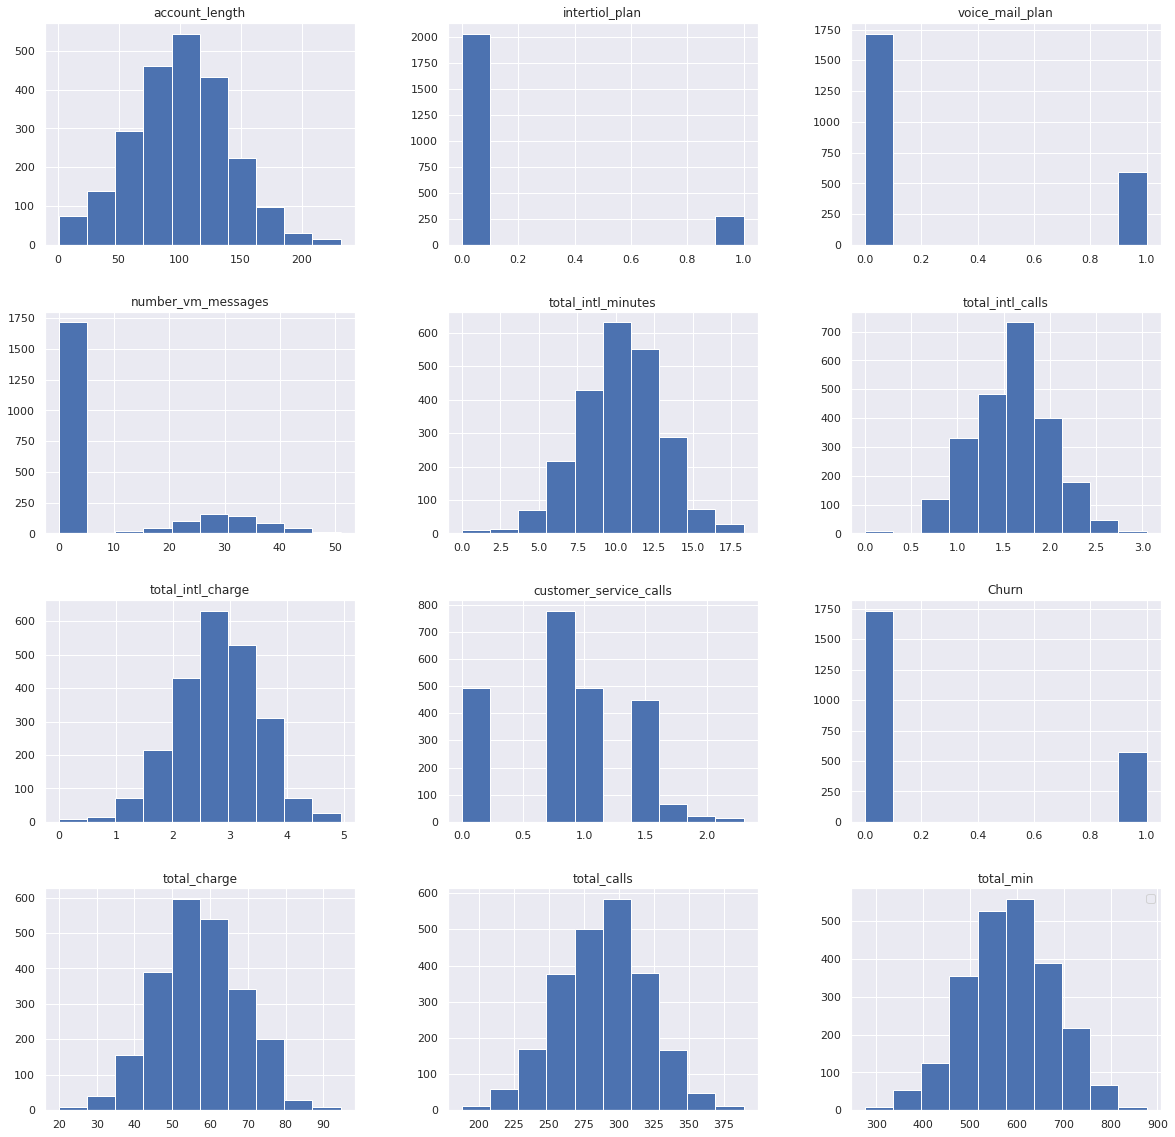

In [ ]:
sns.set()
plt.gcf().clear()
df7.hist(figsize = (20,20))
plt.xlabel('')
plt.legend()

In [ ]:
xgb1 = XGBClassifier(objective='binary:logistic')
#Create x and y variables.
x = df7.drop(columns=['Churn'])
y = df7['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb1.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb1.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)

testx['total_intl_calls'] = np.log(testx['total_intl_calls']+1)
testx['customer_service_calls'] = np.log(testx['customer_service_calls']+1)

predtest = xgb.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred36.csv', index=False)
files.download('pred36.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df6 = df.copy(deep=True)
df6['total_charge'] = df6['total_day_charge'] + df6['total_intl_charge']
df6['total_calls'] = df6['total_day_calls'] + df6['total_intl_calls']
df6['total_min'] = df6['total_day_min'] + df6['total_intl_minutes']
df6.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,1001,15.0,2,0,0,0.0,121.1,130.0,20.59,216.0,...,33.0,10.58,16.1,5.0,4.35,2.0,0,24.94,135.0,137.2
1,1002,105.0,2,0,0,0.0,259.3,96.0,44.08,175.2,...,36.0,10.01,12.0,5.0,3.24,3.0,0,47.32,101.0,271.3
2,1003,97.0,2,0,1,32.0,183.4,94.0,31.18,269.1,...,38.0,9.16,6.7,4.0,1.81,5.0,0,32.99,98.0,190.1
3,1004,121.0,1,0,1,35.0,68.7,95.0,11.68,209.2,...,42.0,8.88,11.4,4.0,3.08,1.0,0,14.76,99.0,80.1
4,1005,98.0,2,0,1,22.0,278.3,89.0,47.31,93.4,...,42.0,4.84,9.7,5.0,2.62,0.0,0,49.93,94.0,288.0


In [ ]:
df6.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_intl_calls', 'total_intl_charge', 'total_intl_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
df6.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,2.0,0,24.94,135.0,137.2
1,105.0,0,0,0.0,3.0,0,47.32,101.0,271.3
2,97.0,0,1,32.0,5.0,0,32.99,98.0,190.1
3,121.0,0,1,35.0,1.0,0,14.76,99.0,80.1
4,98.0,0,1,22.0,0.0,0,49.93,94.0,288.0


In [ ]:
xgb = XGBClassifier()
#Create x and y variables.
x = df6.drop(columns=['Churn'])
y = df6['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       348
           1       0.81      0.66      0.73       115

    accuracy                           0.88       463
   macro avg       0.85      0.80      0.82       463
weighted avg       0.87      0.88      0.87       463

accuracy: - 0.877, f1 score: - 0.727, roc_score: - 0.805


In [ ]:
X = df5.drop(['Churn'],axis=1)
y = df5['Churn']
names = []
scores = []
maes = []
# for name, model in models:
#     model.fit(xtrain, ytrain)
#     y_pred = model.predict(xtest)
#     scores.append(accuracy_score(ytest, y_pred))
#     maes.append(mae(ytest, y_pred))
#     names.append(name)
# tr_split = pd.DataFrame({'Name': names, 'Score': scores, 'MAE': maes})
# print(tr_split)
scorer = make_scorer(f1)
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(model, X, y, cv=kfold, scoring=scorer).mean()

    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


    Name     Score
0    LOG  0.423948
1    SVC  0.010243
2     DT  0.821682
3     RF  0.879055
4     KN  0.530404
5     XG  0.831227
6     LG  0.849914
7    GBT  0.830011
8    ADA  0.718739
9    EXT  0.893965
10   BAG  0.840173
11  HIST  0.858951


In [ ]:
#Create KNN Object.
xgb = XGBClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

In [ ]:
#Create KNN Object.
lg = LGBMClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lg.fit(x_train, y_train)
#Predict test data set.
y_pred = lg.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928


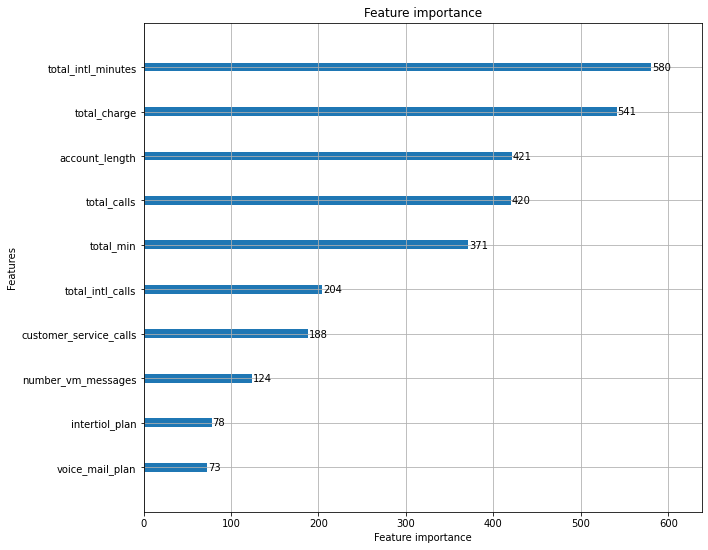

In [ ]:
plot_importance(lg, figsize=(10, 9));

In [ ]:
df2.columns

Index(['account_length', 'intertiol_plan', 'voice_mail_plan',
       'number_vm_messages', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'Churn', 'total_charge',
       'total_calls', 'total_min'],
      dtype='object')

In [ ]:
df3 = df2.copy(deep=True)
df3.drop(['total_intl_charge','intertiol_plan','voice_mail_plan'],axis=1,inplace=True)
df3.head()

,account_length,number_vm_messages,total_intl_minutes,total_intl_calls,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0.0,16.1,5.0,2.0,0,49.53,249.0,572.2
1,105.0,0.0,12.0,5.0,3.0,0,68.98,229.0,656.9
2,97.0,32.0,6.7,4.0,5.0,0,63.21,252.0,656.0
3,121.0,35.0,11.4,4.0,1.0,0,38.34,206.0,475.3
4,98.0,22.0,9.7,5.0,0.0,0,60.09,274.0,479.3


In [ ]:
#Create KNN Object.
lg = LGBMClassifier()
#Create x and y variables.
x = df3.drop(columns=['Churn'])
y = df3['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
lg.fit(x_train, y_train)
#Predict test data set.
y_pred = lg.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       348
           1       0.95      0.83      0.89       115

    accuracy                           0.95       463
   macro avg       0.95      0.91      0.93       463
weighted avg       0.95      0.95      0.95       463

accuracy: - 0.948, f1 score: - 0.889, roc_score: - 0.910


In [ ]:
df2.head()

,account_length,intertiol_plan,voice_mail_plan,number_vm_messages,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,0,0,0.0,16.1,5.0,4.35,2.0,0,49.53,249.0,572.2
1,105.0,0,0,0.0,12.0,5.0,3.24,3.0,0,68.98,229.0,656.9
2,97.0,0,1,32.0,6.7,4.0,1.81,5.0,0,63.21,252.0,656.0
3,121.0,0,1,35.0,11.4,4.0,3.08,1.0,0,38.34,206.0,475.3
4,98.0,0,1,22.0,9.7,5.0,2.62,0.0,0,60.09,274.0,479.3


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = lg.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred26.csv', index=False)
files.download('pred26.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#using SMOTE on xgb without any hyperparameters
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [2, 3, 4, 5, 6, 7]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = LGBMClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=2, ratio=0.5, Mean ROC AUC: 0.979
> k=2, ratio=0.6, Mean ROC AUC: 0.981
> k=2, ratio=0.7, Mean ROC AUC: 0.982
> k=2, ratio=0.8, Mean ROC AUC: 0.982
> k=2, ratio=0.9, Mean ROC AUC: 0.982
> k=2, ratio=1.0, Mean ROC AUC: 0.981
> k=3, ratio=0.5, Mean ROC AUC: 0.980
> k=3, ratio=0.6, Mean ROC AUC: 0.981
> k=3, ratio=0.7, Mean ROC AUC: 0.981
> k=3, ratio=0.8, Mean ROC AUC: 0.981
> k=3, ratio=0.9, Mean ROC AUC: 0.982
> k=3, ratio=1.0, Mean ROC AUC: 0.982
> k=4, ratio=0.5, Mean ROC AUC: 0.979
> k=4, ratio=0.6, Mean ROC AUC: 0.981
> k=4, ratio=0.7, Mean ROC AUC: 0.981
> k=4, ratio=0.8, Mean ROC AUC: 0.981
> k=4, ratio=0.9, Mean ROC AUC: 0.982
> k=4, ratio=1.0, Mean ROC AUC: 0.981
> k=5, ratio=0.5, Mean ROC AUC: 0.979
> k=5, ratio=0.6, Mean ROC AUC: 0.982
> k=5, ratio=0.7, Mean ROC AUC: 0.982
> k=5, ratio=0.8, Mean ROC AUC: 0.982
> k=5, ratio=0.9, Mean ROC AUC: 0.981
> k=5, ratio=1.0, Mean ROC AUC: 0.982
> k=6, ratio=0.5, Mean ROC AUC: 0.979
> k=6, ratio=0.6, Mean ROC AUC: 0.981
> k=6, ratio

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.8, k_neighbors=5)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=3)
xgb = LGBMClassifier()
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       347
           1       1.00      0.95      0.97       279

    accuracy                           0.98       626
   macro avg       0.98      0.97      0.98       626
weighted avg       0.98      0.98      0.98       626

accuracy: - 0.976, f1 score: - 0.972, roc_score: - 0.973


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = xgb.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred27.csv', index=False)
files.download('pred27.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

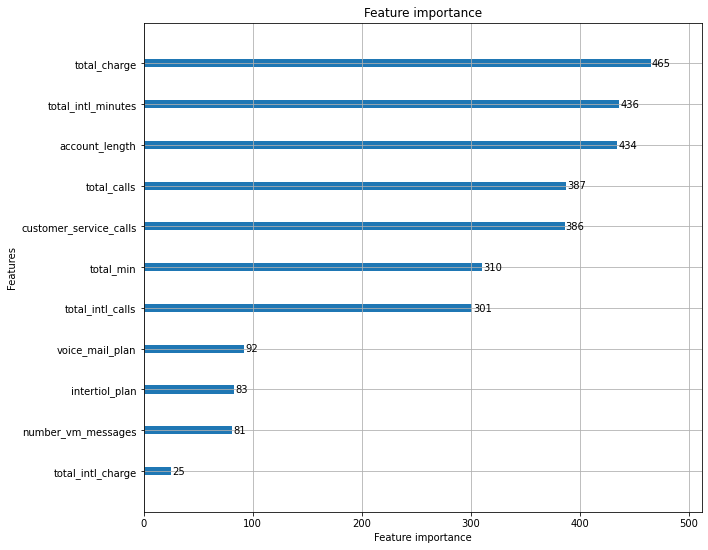

In [ ]:
plot_importance(xgb, figsize=(10, 9));

In [ ]:
df2.columns

Index(['account_length', 'intertiol_plan', 'voice_mail_plan',
       'number_vm_messages', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'Churn', 'total_charge',
       'total_calls', 'total_min'],
      dtype='object')

In [ ]:
df4 = df2.copy(deep=True)
df4.drop(['total_intl_charge','number_vm_messages','intertiol_plan','voice_mail_plan'],axis=1,inplace=True)
df4.head()

,account_length,total_intl_minutes,total_intl_calls,customer_service_calls,Churn,total_charge,total_calls,total_min
0,15.0,16.1,5.0,2.0,0,49.53,249.0,572.2
1,105.0,12.0,5.0,3.0,0,68.98,229.0,656.9
2,97.0,6.7,4.0,5.0,0,63.21,252.0,656.0
3,121.0,11.4,4.0,1.0,0,38.34,206.0,475.3
4,98.0,9.7,5.0,0.0,0,60.09,274.0,479.3


In [ ]:
X = df4.drop(columns=['Churn'])
y = df4['Churn']
oversample = SMOTE(sampling_strategy=0.8, k_neighbors=5)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=3)
xgb = LGBMClassifier()
xgb.fit(x_train, y_train)
#Predict test data set.
y_pred = xgb.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       347
           1       0.94      0.92      0.93       279

    accuracy                           0.94       626
   macro avg       0.94      0.94      0.94       626
weighted avg       0.94      0.94      0.94       626

accuracy: - 0.939, f1 score: - 0.931, roc_score: - 0.937


In [ ]:
#Create KNN Object.
rf = RandomForestClassifier()
#Create x and y variables.
x = df2.drop(columns=['Churn'])
y = df2['Churn']
#Split data into training and testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3,stratify=y)
#Training the model.
rf.fit(x_train, y_train)
#Predict test data set.
y_pred = rf.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       348
           1       0.98      0.86      0.92       115

    accuracy                           0.96       463
   macro avg       0.97      0.93      0.95       463
weighted avg       0.96      0.96      0.96       463

accuracy: - 0.961, f1 score: - 0.917, roc_score: - 0.928


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = rf.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred28.csv', index=False)
files.download('pred28.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#using SMOTE on xgb without any hyperparameters
X = df2.drop(['Churn'],axis=1)
y = df2['Churn']
k_values = [2, 3, 4, 5, 6, 7]
ratios = [0.5,0.6,0.7,0.8,0.9,1]
for k in k_values:
  for ratio in ratios:
    # define pipeline
    model = RandomForestClassifier() #leaf_size=1, n_neighbors=23, p=1
    over = SMOTE(sampling_strategy=ratio, k_neighbors=k)
    # under = RandomUnderSampler(sampling_strategy=ratio)
    steps = [('over', over), ('model', model)] #second one in list - ('under', under),
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print('> k=%d, ratio=%.1f, Mean ROC AUC: %.3f' % (k, ratio, score))

> k=2, ratio=0.5, Mean ROC AUC: 0.985
> k=2, ratio=0.6, Mean ROC AUC: 0.985
> k=2, ratio=0.7, Mean ROC AUC: 0.984
> k=2, ratio=0.8, Mean ROC AUC: 0.984
> k=2, ratio=0.9, Mean ROC AUC: 0.983
> k=2, ratio=1.0, Mean ROC AUC: 0.984
> k=3, ratio=0.5, Mean ROC AUC: 0.985
> k=3, ratio=0.6, Mean ROC AUC: 0.985
> k=3, ratio=0.7, Mean ROC AUC: 0.983
> k=3, ratio=0.8, Mean ROC AUC: 0.984
> k=3, ratio=0.9, Mean ROC AUC: 0.983
> k=3, ratio=1.0, Mean ROC AUC: 0.983
> k=4, ratio=0.5, Mean ROC AUC: 0.984
> k=4, ratio=0.6, Mean ROC AUC: 0.985
> k=4, ratio=0.7, Mean ROC AUC: 0.985
> k=4, ratio=0.8, Mean ROC AUC: 0.984
> k=4, ratio=0.9, Mean ROC AUC: 0.983
> k=4, ratio=1.0, Mean ROC AUC: 0.983
> k=5, ratio=0.5, Mean ROC AUC: 0.985
> k=5, ratio=0.6, Mean ROC AUC: 0.983
> k=5, ratio=0.7, Mean ROC AUC: 0.984
> k=5, ratio=0.8, Mean ROC AUC: 0.982
> k=5, ratio=0.9, Mean ROC AUC: 0.984
> k=5, ratio=1.0, Mean ROC AUC: 0.983
> k=6, ratio=0.5, Mean ROC AUC: 0.985
> k=6, ratio=0.6, Mean ROC AUC: 0.986
> k=6, ratio

In [ ]:
X = df2.drop(columns=['Churn'])
y = df2['Churn']
oversample = SMOTE(sampling_strategy=0.5, k_neighbors=3)
x_over, y_over = oversample.fit_resample(X, y)
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=3)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
#Predict test data set.
y_pred = rf.predict(x_test)
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred))
#Checking performance our model with ROC Score.
print("accuracy: - %.3f, f1 score: - %.3f, roc_score: - %.3f" %(acc(y_test,y_pred),f1(y_test,y_pred),roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       355
           1       0.97      0.87      0.92       166

    accuracy                           0.95       521
   macro avg       0.96      0.93      0.94       521
weighted avg       0.95      0.95      0.95       521

accuracy: - 0.952, f1 score: - 0.921, roc_score: - 0.931


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)

testx = testdf.copy(deep=True)
testx['total_charge'] = testx['total_day_charge'] + testx['total_eve_charge'] + testx['total_night_charge']
testx['total_calls'] = testx['total_day_calls'] + testx['total_eve_calls'] + testx['total_night_calls']
testx['total_min'] = testx['total_day_min'] + testx['total_eve_min'] + testx['total_night_minutes']

testx.drop(['total_day_min', 'location_code', 'customer_id',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge'],axis=1,inplace=True)
predtest = rf.predict(testx)
testdf['Churn'] = predtest
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.to_csv('pred29.csv', index=False)
files.download('pred29.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def getScores(df):
  X = df.drop(['Churn'],axis=1)
  y = df['Churn']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
  # model = XGBClassifier()
  model = LGBMClassifier()
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  print(acc(y_test,preds))
  print(f1(y_test,preds))
  return model

In [ ]:
model = getScores(df2)

0.9438444924406048
0.8761904761904763


In [ ]:
X = df.drop(['customer_id','Churn'],axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(acc(y_test,preds))
print(f1(y_test,preds))

0.9200863930885529
0.8229665071770336


In [ ]:
testdf = pd.read_csv('Test_Dataset_190604N.csv')
testdf.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,3322,91,445.0,yes,no,0.0,258.4,112.0,42.89,190.0,93,14.47,158.6,105.0,7.09,12.1,3.0,3.27,2.0
1,3323,113,445.0,no,yes,20.0,155.8,81.0,28.83,168.5,62,13.73,275.5,105.0,12.22,8.7,3.0,2.35,5.0
2,3324,122,445.0,no,no,0.0,237.2,137.0,40.30,263.8,134,22.76,251.3,105.0,10.81,8.8,4.0,2.38,1.0
3,3325,103,445.0,no,no,0.0,133.6,117.0,23.60,156.1,130,13.37,207.2,105.0,9.95,10.4,7.0,2.81,8.0
4,3326,111,452.0,no,no,0.0,115.6,120.0,24.54,211.1,66,18.79,140.9,105.0,5.76,12.7,1.0,3.43,4.0


In [ ]:
scale_mapper = {"yes":1, "no":0}
scale_mapper1 = {"Yes":1, "No":0}
scale_mapper2 = {445:1, 452:2, 547:3}
testdf["intertiol_plan"] = testdf["intertiol_plan"].replace(scale_mapper)
testdf["voice_mail_plan"] = testdf["voice_mail_plan"].replace(scale_mapper)
testdf["location_code"] = testdf["location_code"].replace(scale_mapper2)
testdf.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
0,3322,91,1.0,1,0,0.0,258.4,112.0,42.89,190.0,93,14.47,158.6,105.0,7.09,12.1,3.0,3.27,2.0
1,3323,113,1.0,0,1,20.0,155.8,81.0,28.83,168.5,62,13.73,275.5,105.0,12.22,8.7,3.0,2.35,5.0
2,3324,122,1.0,0,0,0.0,237.2,137.0,40.30,263.8,134,22.76,251.3,105.0,10.81,8.8,4.0,2.38,1.0
3,3325,103,1.0,0,0,0.0,133.6,117.0,23.60,156.1,130,13.37,207.2,105.0,9.95,10.4,7.0,2.81,8.0
4,3326,111,2.0,0,0,0.0,115.6,120.0,24.54,211.1,66,18.79,140.9,105.0,5.76,12.7,1.0,3.43,4.0


In [ ]:
testx = testdf.drop(['customer_id','voice_mail_plan','total_day_min','total_eve_min','total_night_minutes','total_intl_minutes'],axis=1)

In [ ]:
testx.head()

,account_length,location_code,intertiol_plan,number_vm_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls
0,91,1.0,1,0.0,112.0,42.89,93,14.47,105.0,7.09,3.0,3.27,2.0
1,113,1.0,0,20.0,81.0,28.83,62,13.73,105.0,12.22,3.0,2.35,5.0
2,122,1.0,0,0.0,137.0,40.30,134,22.76,105.0,10.81,4.0,2.38,1.0
3,103,1.0,0,0.0,117.0,23.60,130,13.37,105.0,9.95,7.0,2.81,8.0
4,111,2.0,0,0.0,120.0,24.54,66,18.79,105.0,5.76,1.0,3.43,4.0


In [ ]:
predtest = model.predict(testx)
testdf['Churn'] = predtest
testdf.head()

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn
0,3322,91,1.0,1,0,0.0,258.4,112.0,42.89,190.0,93,14.47,158.6,105.0,7.09,12.1,3.0,3.27,2.0,0
1,3323,113,1.0,0,1,20.0,155.8,81.0,28.83,168.5,62,13.73,275.5,105.0,12.22,8.7,3.0,2.35,5.0,1
2,3324,122,1.0,0,0,0.0,237.2,137.0,40.30,263.8,134,22.76,251.3,105.0,10.81,8.8,4.0,2.38,1.0,1
3,3325,103,1.0,0,0,0.0,133.6,117.0,23.60,156.1,130,13.37,207.2,105.0,9.95,10.4,7.0,2.81,8.0,1
4,3326,111,2.0,0,0,0.0,115.6,120.0,24.54,211.1,66,18.79,140.9,105.0,5.76,12.7,1.0,3.43,4.0,1


In [ ]:
scale_mapper = {1:'Yes', 0:'No'}
testdf["Churn"] = testdf["Churn"].replace(scale_mapper)

In [ ]:
testdf.shape

(1500, 20)

In [ ]:
testdf.columns

Index(['customer_id', 'account_length', 'location_code', 'intertiol_plan',
       'voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'Churn'],
      dtype='object')

In [ ]:
testdf.drop(['account_length','location_code','intertiol_plan','voice_mail_plan', 'number_vm_messages', 'total_day_min',
       'total_day_calls', 'total_day_charge', 'total_eve_min',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',],axis=1,inplace=True)
testdf.head()

,customer_id,Churn
0,3322,No
1,3323,Yes
2,3324,Yes
3,3325,Yes
4,3326,Yes


In [ ]:
testdf.to_csv('pred3.csv', index=False)
files.download('pred3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>